In [1]:
import numpy as np
import matplotlib.pyplot  as plt
import pandas as pd


In [2]:
from sklearn.metrics import mean_squared_error as MSE
from scipy import optimize as scop

In [3]:
from numba import njit
@njit
def rush_larsen_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = y[i-1] + (x[i-1] - y[i-1]) * np.exp(c[i-1])
 

In [4]:
if False:#True:
    t0 = np.arange(0,10,5e-6)
    tt = 10
    time = []
    for k in range(0, 78 * tt):
        time.append(t0[k])
    for k in range(0, 1000 * tt):
        time.append(t0[k])
    for k in range(0, 1000 * tt):
        time.append(t0[k])
    for k in range(0, 2000 * tt):
        time.append(t0[k])
    for k in range(0, 922 * tt):
        time.append(t0[k])
    np.save('time_5e-6', time)

t_step = np.load('time_1e-5.npy')
len(t_step)

25000

$$ \frac{\partial V_{p}}{\partial t} = \frac{V_{c} - V_{p}}{C_{p}*R_{p}} \\ $$
$$ \frac{\partial V_{m}}{\partial t} = \frac{V_{p} + V_{off} - V_{m}}{C_{m}*R_{s}} - \frac{I_{ion}+I_{leak}}{C_m} \\ $$
$$ \frac{\partial m}{\partial t} = \frac{m_{inf} - m}{\tau_{m}}  \\ $$
$$ \frac{\partial h}{\partial t} = \frac{h_{inf} - h}{\tau_{h}}  \\ $$
$$
I_{m} = C_{m} *\frac{\partial V_{m}}{\partial t} \\
I_{p} = C_{p} *\frac{\partial V_{p}}{\partial t} \\
I_{leak} = g_{leak} * V_{m}
$$

In [5]:
@njit
def rush_larsen_easy_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = y[i-1] + (x[i-1] - y[i-1]) * np.exp(c)
        
@njit
def euler_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = x[i-1] + (y[i-1] - x[i-1]) * c
@njit
def initial_state(v_rev,v_p,v_m,m_inf,h_inf,m,h,j,I_leak,I_Na,x):
    c_p, c_m, a0_m, b0_m, delta_m, s_m, a0_h, b0_h, delta_h, s_h, a0_j, b0_j, delta_j, s_j,tau_j_const,\
    r_m, r_p, g_max, g_leak, v_half_m,v_half_h, k_m, k_h, v_off = x
    for i in range(0, 5000):
        v_c = -80
        
        #from Roman
        alpha_m  = a0_m * np.exp( v_m / (s_m))
        beta_m = b0_m * np.exp( v_m / (-delta_m))

        alpha_h  = a0_h * np.exp(v_m / (-s_h))
        beta_h = b0_h * np.exp( v_m / delta_h)

        
        #alpha_m  = a0_m * np.exp( v_m / (s_m)) 
        #beta_m = b0_m * np.exp( v_m / (-delta_m))
        
        #alpha_h  = a0_h * np.exp(v_m / (s_h)) 
        #beta_h = b0_h * np.exp( v_m/ (-delta_h))
        
        alpha_j  = a0_j * np.exp( v_m / (s_j)) 
        beta_j = b0_j * np.exp( v_m / (-delta_j))
        
        tau_m = 1 / (beta_m + alpha_m)#+0.000037
        tau_h = 1 / (beta_h + alpha_h)#+0.0002       
        tau_j = tau_j_const + 1 / (beta_j + alpha_j) 

        v_p = v_c + (v_p - v_c) * np.exp(-dt / (r_p * c_p))
        v_m = v_m + (v_p + v_off - v_m ) * (dt / (r_m * c_m)) - 1e-9 * (I_Na + I_leak) * dt/ c_m 
        
        m = m_inf + (m - m_inf)*np.exp(-dt/tau_m)
        h = h_inf + (h - h_inf)*np.exp(-dt/tau_h)
        j = h_inf + (j - h_inf)*np.exp(-dt/tau_j)
        
        m_inf = 1 / (1 + np.exp((- v_half_m - v_m) / k_m))
        h_inf = 1 / (1 + np.exp((v_half_h + v_m) / k_h))
        
        I_leak = g_leak * v_m
        I_Na = g_max * h * (m**3) * (v_m - v_rev)# * j 
    return v_p,v_m, m_inf,h_inf, m,h,j, I_leak, I_Na

        
@njit
def calculate_cicle(n,t,v_c, v_rev, x):
    c_p, c_m, a0_m, b0_m, delta_m, s_m, a0_h, b0_h, delta_h, s_h, a0_j, b0_j, delta_j, s_j,tau_j_const,\
    r_m, r_p, g_max, g_leak, v_half_m,v_half_h, k_m, k_h, v_off = x
    #alpha_m = np.zeros_like(t)
    #beta_m = np.zeros_like(t)
    #alpha_h = np.zeros_like(t)
    #beta_h = np.zeros_like(t)
    
    tau_m = np.zeros_like(t)
    tau_h = np.zeros_like(t)
    tau_j = np.zeros_like(t)
    
    m_inf = np.zeros_like(t)
    h_inf = np.zeros_like(t)
    
    v_p = np.zeros_like(t)
    v_m = np.zeros_like(t)
    
    m = np.zeros_like(t)
    h = np.zeros_like(t)
    j = np.zeros_like(t)
    
    I_leak = np.zeros_like(t)
    I_Na = np.zeros_like(t)
    
    v_p[0] = -80
    v_m[0] = -80
    m_inf[0] = 0
    h_inf[0] = 1
    m[0] = 0
    h[0] = 1
    n_step = len(t)
    
    dt = t[1] - t[0]
    I_leak[0] = g_leak * v_m[0]
    
    time_ = 25000 #25000
    v_p[0],v_m[0],m_inf[0],h_inf[0],m[0],h[0],j[0],I_leak[0],I_Na[0] = \
    initial_state(v_rev,v_p[0],v_m[0],m_inf[0],h_inf[0],m[0],h[0],j[0],I_leak[0],I_Na[0],x)
    #I_Na[0] = g_max * h[0] * (m[0]**3) * (v_m[0] - v_rev)
    #n=5
    for i in range(1, n_step):
        if i/time_+1 == i//time_+1:

            v_p[i-1], v_m[i-1],m_inf[i-1], h_inf[i-1], m[i-1], h[i-1], j[i-1], I_leak[i-1], I_Na[i-1] =\
            initial_state(v_rev, v_p[i-1], v_m[i-1], m_inf[i-1], h_inf[i-1],
                          m[i-1], h[i-1], j[i-1], I_leak[i-1], I_Na[i-1], x)

            
        v_p[i] = v_c[i-1] + (v_p[i-1] - v_c[i-1])*np.exp(-dt / (r_p * c_p))
        v_m[i] = v_m[i-1] + (v_p[i-1]+ v_off - v_m[i-1])*(dt / (r_m * c_m))\
                - 1e-9 * (I_Na[i-1] + I_leak[i-1]) * dt/ c_m 
        
        #from Roman
        alpha_m  = a0_m * np.exp( v_m[i-1] / (s_m))
        beta_m = b0_m * np.exp( v_m[i-1] / (-delta_m))
        
        alpha_h  = a0_h * np.exp(v_m[i-1] / (-s_h))
        beta_h = b0_h * np.exp( v_m[i-1] / delta_h)


        #alpha_m  = a0_m * np.exp( v_m[i-1] / s_m) 
        #beta_m = b0_m * np.exp( v_m[i-1] / (-delta_m))
        
        #alpha_h  = a0_h * np.exp(v_m[i-1] / s_h) 
        #beta_h = b0_h * np.exp( v_m[i-1] / (-delta_h))

        alpha_j  = a0_j * np.exp(v_m[i-1] / s_j) 
        beta_j = b0_j * np.exp( v_m[i-1] / (-delta_j))
        
        tau_m[i-1] = 1 / (beta_m + alpha_m)#+0.000037
        tau_h[i-1] = 1 / (beta_h + alpha_h)#+0.0002
        tau_j[i-1] = tau_j_const + 1 / (beta_j + alpha_j) 
 
        #m_inf = 1/(1+beta_m/alpha_m)
        #h_inf = 1/(1+beta_h/alpha_h)
        
        m[i] = m_inf[i-1] + (m[i-1] - m_inf[i-1])*np.exp(-dt/tau_m[i-1])
        h[i] = h_inf[i-1] + (h[i-1] - h_inf[i-1])*np.exp(-dt/tau_h[i-1])
        j[i] = h_inf[i-1] + (j[i-1] - h_inf[i-1])*np.exp(-dt/tau_j[i-1])
        
        
        m_inf[i] = 1 / (1 + np.exp((- v_half_m - v_m[i]) / k_m))
        h_inf[i] = 1 / (1 + np.exp((v_half_h + v_m[i]) / k_h))
        
        I_leak[i] = g_leak * v_m[i]
        I_Na[i] = g_max  * h[i] * (m[i]**3) * (v_m[i] - v_rev)#* j[i]
    
    tau_m[-1] = 1 / (a0_m * np.exp( v_m[-1] / (s_m))
                          +  b0_m * np.exp( v_m[-1] / (-delta_m)))
    tau_h[-1] = 1 / (a0_h * np.exp(v_m[-1] / (-s_h))
                          +  b0_h * np.exp( v_m[-1] / delta_h))
    
    tau_j[-1] = 1 / (a0_j * np.exp(v_m[-1] / (-s_j))
                          +  b0_j * np.exp( v_m[-1] / delta_j))
    
    return m_inf[::n], h_inf[::n], tau_m[::n], tau_h[::n], tau_j[::n], v_p, v_m, I_leak[::n], I_Na[::n]



def calculate_I_out(x, *args):#, s0, c, protocol, ...):
    #print(x)
    y = x.copy()
    kwargs = args[-1]
    
    t = kwargs['t']
    dt = t[1] - t[0]
    
    n = int(5e-5/dt)
    
    v_list = kwargs['v_list']
    k_list = kwargs['k_list'] * n
    
    if kwargs.get('log_scale', False):
        y[:-1] = np.exp(y[:-1])
        #y = np.exp(y)
        assert np.all(y[:-1] > 0) 
    
    c_p, c_m, a0_m, b0_m, delta_m, s_m, a0_h, b0_h, delta_h, s_h, a0_j, b0_j, delta_j, s_j,tau_j_const,\
    r_m, r_p, g_max, g_leak, v_half_m,v_half_h, k_m, k_h, v_off = y
    #print(c_p)
    # constructing v_c - command potential

    count = np.zeros_like(t)
    count[k_list] = 1
    count = np.cumsum(count) 
    
    
    v_c = np.zeros_like(t)
    v_c = v_list[count.astype(int)]

    v_rev = 18
   
    
    I_error = np.zeros(len(t)//n)
    try:
        m_inf, h_inf, tau_m, tau_h, tau_j, v_p, v_m, I_leak, I_Na = calculate_cicle(n,t,v_c, v_rev, y)
    except ZeroDivisionError:
        I_error+=1e100
        #print(x)
        return I_error
        #print('ok')
    #I_p = np.zeros_like(t)
    #I_c = np.zeros_like(t)
    I_c = 1e9 * c_m * (np.diff(v_m) / dt)[::n]
    I_p = 1e9 * c_p * (np.diff(v_p) / dt)[::n]
    if len(I_c) != len(I_Na):
        I_c = np.concatenate((I_c,I_c[-1:]))
        I_p = np.concatenate((I_p,I_p[-1:]))
    
    tau_z = 5e-4 # 1e-12 * 5e8
    
    I_in = I_c  + I_leak + I_Na + I_p
    I_out = np.zeros_like(I_in)
    #print(len(I_in))
    
    #euler_numba_helper(I_out,I_in,(dt / tau_z))  
    I_out[0] = I_in[0]
    
    rush_larsen_easy_numba_helper(I_out, I_in, - dt * n / tau_z)
    
    if kwargs.get('graph', True):
        #plt.plot(V_m_list, label = 'command')
        plt.figure()
        plt.plot(v_c[::], label = 'command_prediction')
        plt.plot(v_p, label = 'pipette', ls = '--')
        plt.plot(v_m, label = 'membrane',ls = '-.')
        plt.legend()
        v_graph = np.arange(-95,35)
        
       
        
        #m_graph = 1 / (1 + np.exp((- v_half_m - v_graph) / k_m))
        #h_graph = 1 / (1 + np.exp((v_half_h + v_graph) / k_h))
        #plt.plot(v_graph, m_graph, label = 'm_inf')
        #plt.plot(v_graph, h_graph, label = 'h_inf')
        plt.figure()
        plt.plot( m_inf, label = 'm_inf')
        plt.plot( h_inf, label = 'h_inf')
        plt.legend()
        
        plt.figure() 
        #tau_m_graph = 1 / (b0_m * np.exp((1-delta_m) * v_graph / (-s_m))
        #                  + a0_m * np.exp( v_m[i-1] / (s_m)) 
        #tau_h_graph = 1 / (b0_h * np.exp((1-delta_h) * v_graph / (-s_h))
        #                  + a0_h * np.exp(-delta_h * v_graph / (-s_h)))
        
        tau_m_graph = 1 / (a0_m * np.exp( v_graph / (s_m))
                          +  b0_m * np.exp( v_graph / (-delta_m)))
        tau_h_graph = 1 / (a0_h * np.exp(v_graph / (-s_h))
                          +  b0_h * np.exp( v_graph / (delta_h)))
        tau_j_graph = tau_j_const + 1 / (a0_j * np.exp(v_graph / (s_j))
                          +  b0_j * np.exp( v_graph / (-delta_j)))
        plt.plot(v_graph, tau_m_graph, label = 'tau_m')
        plt.plot(v_graph, tau_h_graph, label = 'tau_h')
        #plt.plot(v_graph, tau_j_graph, label = 'tau_j')
        #plt.plot(tau_m, label = 'tau_m')
        #plt.plot(tau_h, label = 'tau_h')
        plt.legend()

        plt.figure()
        plt.plot(I_c, label = 'I_c')
        plt.plot(I_p, label = 'I_p')
        plt.plot(I_leak, label = 'I_leak')
        plt.plot(I_Na, label = 'I_Na',ls = '-.')
        plt.legend()
        

        plt.figure()
        #plt.plot(I_in, label = 'I_in')
        plt.plot(I_out, label = 'I_out')
        plt.legend() 



    return I_out


In [6]:
k_list = np.array([77, 1077, 2077, 4077])
v_list = np.array([-80, -70, -80, -80])
k_all = k_list
v_all = v_list
for l in range(1,20):
    k_all = np.concatenate([k_all, k_list+5000*l])
    v_all = np.concatenate([v_all, v_list+[0,  0, 0, 5*l]])
v_all = np.concatenate([v_all,[-80]])
t = np.load('../data/time.npy')
t_all = np.concatenate([t for k in range(20)])


In [7]:
k_list_1 = np.array([77, 1077, 2077, 4077])
v_list_1 = np.array([-80,-70,-80, -10, -80])

In [8]:
def log_x(a):
    b = a.copy()
    b[2:10] = np.log(a[2:10])
    b[14:18] = np.log(a[14:18])
    return(b)


In [10]:
%matplotlib inline
#%matplotlib notebook
plt.style.use('../styles/general.mplstyle')

<ipython-input-5-94e6110c9262>:242: RuntimeWarning: overflow encountered in exp
  +  b0_m * np.exp( v_graph / (-delta_m)))
<ipython-input-5-94e6110c9262>:242: RuntimeWarning: overflow encountered in multiply
  +  b0_m * np.exp( v_graph / (-delta_m)))


5000

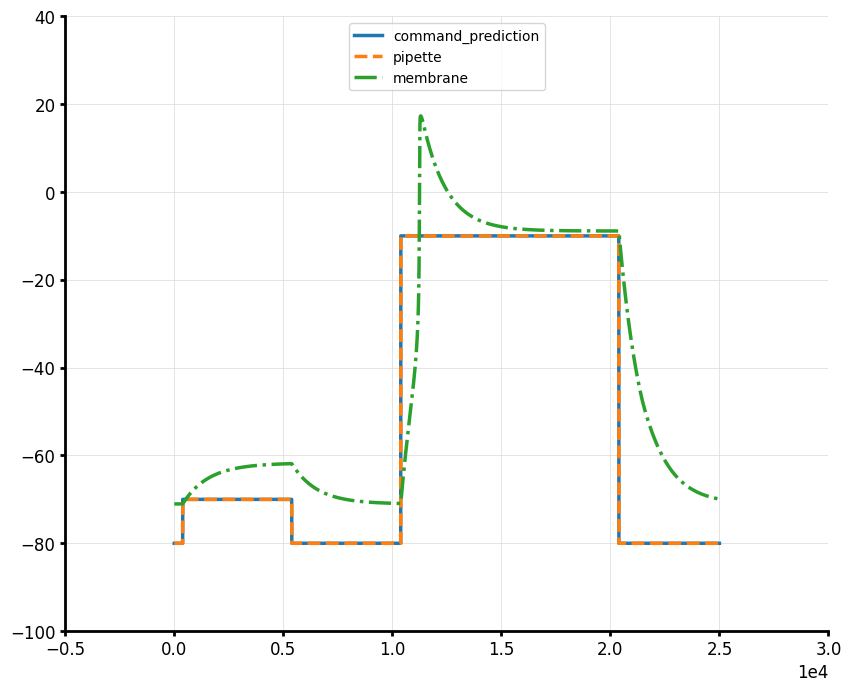

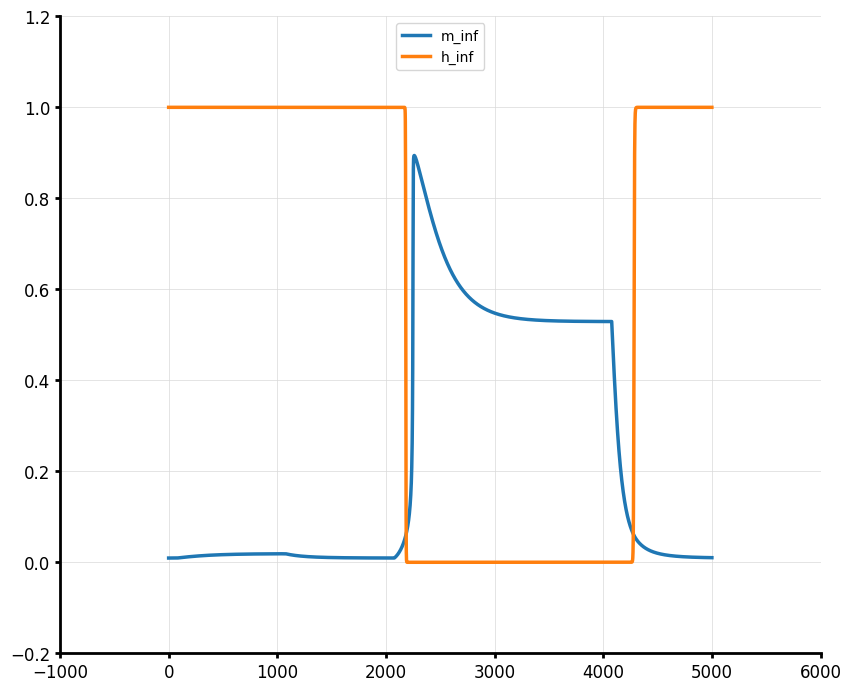

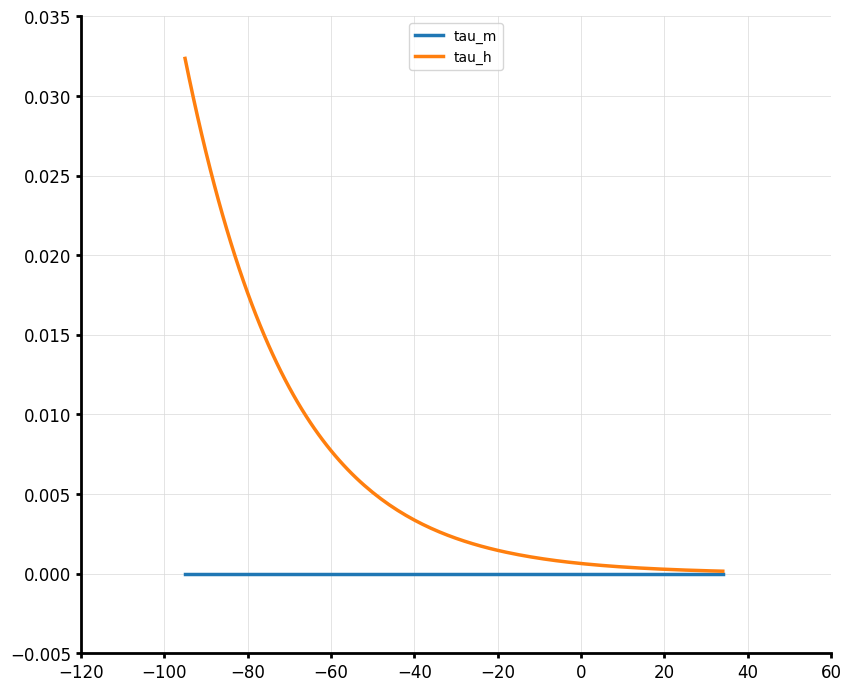

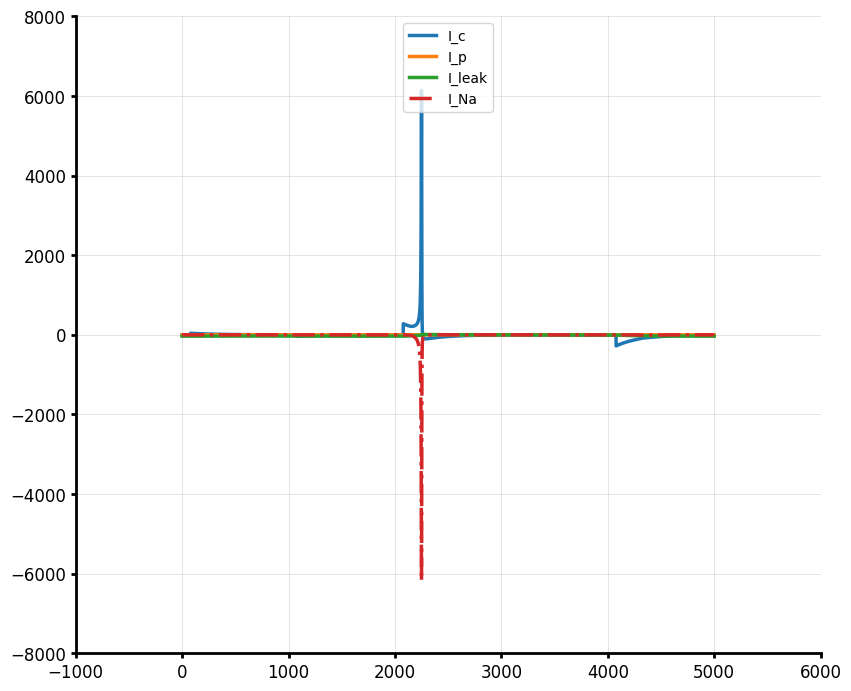

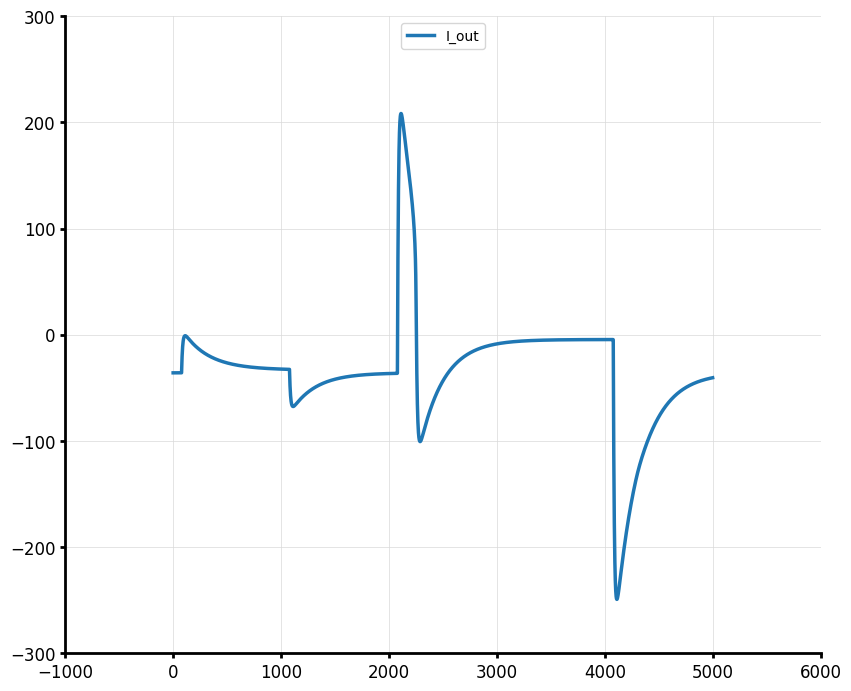

In [11]:
#p0 = np.array([6e-16, 6e-12, 2e3,  1.6e3,   0.9,   60,  1e-1,   4e2,    0.3,     3,    8e8,   5e3,  13,   2e-1, 11, 52,0.2,0.3,10])
#x_true = [6e-15, 12e-12, 5e4,  8e-2,   0.3,   60,  1e-3,   4e2,    0.08,     22,    5e8,   1e6,   5e1,   1e-1]
#p0 = np.array([6e-16, 5e-11, 90e+1,  3.9,8.21,   12.8,    6.3,   1.75e02,    6.72,  21.65,    5e6,   5e5,5e1,   5e-2,20,53,5,0.66, 5])
#             C_p     C     a0_m  b0_m  delta_m  s_m   a0_h  b0_h    delta_h      s_h      R    R_p   g_max  g_leak  "v_half_m", "v_half_h", "k_m", "k_h", "v_off"

#from Roman
#p0 = np.array([6e-16, 5e-11, 90e1,  3.9,   8.21,   12.8,    6.3,   1.75e02,    6.72,    21.65,   5e6,   5e4,  5e1,   5e-0,20,53,5,0.66, 0])
p0 = np.array([6e-16, 5e-11,#C_p , C
               24e9,  69,   0.12,  2857,#a0_m , b0_m , delta_m , s_m 
               0.115, 1571, 24,    46,#a0_h , b0_h , delta_h , s_h 
               3.132e+03, 1.132e-04, 8.281e+00, 3.845e+01, 2.038e-03,#a0_j , b0_j , delta_j , s_j , tau_j_const
               250e6,   7e4,  4276,  5e-01, #R , R_p , g_max , g_leak 
               10.4,  46.4, 13,    0.28,#v_half_m , v_half_h , k_m, k_h
               0])#v_off





if False:
    p0 = np.array([6.000e-16, 1.200e-11,#C_p , C
               9.454e+03, 1.931e-02, 5.955e+00, 3.477e+01,#a0_m , b0_m , delta_m , s_m 
               6.305e+03, 1.184e-02, 6.285e+00, 2.027e+01,#a0_h , b0_h , delta_h , s_h 
               3.132e+02, 1.132e-04, 8.281e+00, 3.845e+01, 2.038e-03,#a0_j , b0_j , delta_j , s_j , tau_j_const
               5.000e+07, 5.000e+05, 5.000e+02, 5.000e-00, #R , R_p , g_max , g_leak  
               2.000e+01, 5.300e+01, 5.000e+00, 6.600e-01,#v_half_m , v_half_h , k_m, k_h
               5.000e-01])#v_off


#x_true_log = np.log(p0)
x_true_log = np.concatenate((np.log(p0[:-1]),p0[-1:]))
#print(len(x_true_log))

#t = np.load('../data/time.npy')

v_list = v_all#np.array([-80, -80, -70, -80, -10, -80])
k_list = k_all#np.array([77, 1077, 2077, 4077]) 
dt = t[1] - t[0]

kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t_step,
              log_scale = True,
              graph = True)#,
              #sample_weights = sample_weight)

data = calculate_I_out(x_true_log, kwargs)

#print(p0)
#print(data)
#plt.plot(data)
len(data)

In [12]:
#%matplotlib notebook
#plt.plot(v_c, label = 'command_prediction')
#plt.plot(v_p, label = 'pipette', ls = '--')
#plt.plot(v_m, label = 'membrane')
#plt.legend()
#v_graph = np.arange(-95,35)
#plt.show()

In [13]:
def loss(x, *args):
    kwargs = args[-1]
    data = args[0]
    sample_weight = kwargs.get('sample_weight', None)
    I_out = calculate_I_out(x, *args)
    
    if np.any(np.isnan(I_out)):
        return np.inf
    if np.any(np.isinf(I_out)):
        return np.inf
        
    return MSE(data, I_out, sample_weight=sample_weight)

In [14]:
%%timeit
kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = False)
loss(x_true_log, data, kwargs)

2.13 ms ± 92.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
names =  ["C_f","C",
          "a0_m","b0_m","delta_m","s_m",
          "a0_h","b0_h" ,"delta_h","s_h",
          "a0_j","b0_j" ,"delta_j","s_j","tau_j_const",
          "R"   , "R_f"  , "g_max"  ,"g_leak",
          "v_half_m", "v_half_h", "k_m", "k_h", "v_off" ]

kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = False)
x0 = x_true_log + 1
bounds = np.vstack([x_true_log  - 2, x_true_log + 2]).T#
#bounds = ([1e-18, 1e-13, 1e-10, 1e-10, -1e2,  1e-10, 1e-10, 1e-10, 1e-10,-1e3, 1e5,  1e3,  1e-5, 1e-5,  1e-4,     1e-4,   1e-4,1e-4,-50],
#          [1e-11,  1e-10, 1e8,   1e6,   1,      1e4,   1e8,   1e8,   1,     1e8,   1e15, 1e15, 1e5,  1e5,   100,      100,    1e2, 1e2,50])
log_bounds = np.vstack([np.concatenate((np.log(bounds[0][:-1]), bounds[0][-1:])),\
                        np.concatenate((np.log(bounds[1][:-1]), bounds[1][-1:]))]).T
#log_bounds = np.vstack([np.log(bounds[0]),np.log(bounds[1])]).T

loss(x0, data, kwargs)

<ipython-input-15-b0f31e607216>:17: RuntimeWarning: invalid value encountered in log
  log_bounds = np.vstack([np.concatenate((np.log(bounds[0][:-1]), bounds[0][-1:])),\
<ipython-input-15-b0f31e607216>:18: RuntimeWarning: invalid value encountered in log
  np.concatenate((np.log(bounds[1][:-1]), bounds[1][-1:]))]).T


1959.0080051129162

In [18]:
%matplotlib inline
plt.style.use('../styles/general.mplstyle')

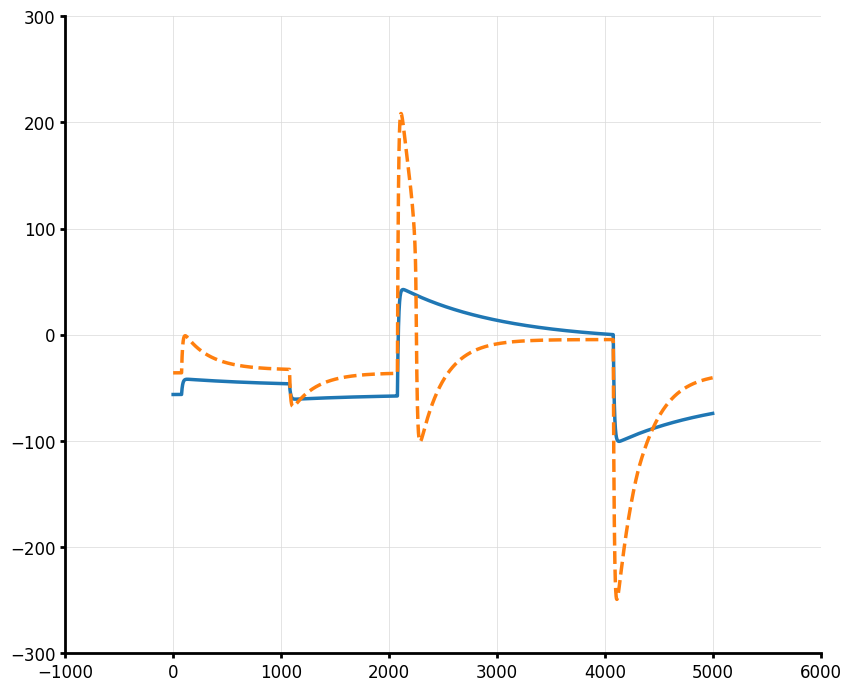

In [19]:
plt.plot(calculate_I_out(x0, kwargs))
plt.plot(data, '--')

### minimize

In [20]:
#%%time
#res = scop.minimize(loss, x0, bounds=bounds, args=(data, kwargs))
#C_p C a0_m b0_m  delta_m  s_m   a0_h  b0_h    delta_h      s_h      R    R_p   g_max  g_leak  "v_half_m", "v_half_h", "k_m", "k_h", "v_off"
kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = False)
res = scop.minimize(loss, x0, bounds = bounds, args=(data, kwargs),method = 'Nelder-Mead',
                    options={ 'adaptive':True, 'maxiter':10000})

/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


In [21]:
loss(res.x, data, kwargs)

580.5875787286088

In [22]:
print('error in param = ' ,x_true_log - res.x)

error in param =  [ 2.08314229e+01  6.06535674e-01 -2.86315031e+02 -2.19032676e+00
 -2.17315422e+01 -1.04576428e+02  6.72659925e+00 -1.86559832e+00
 -2.23850657e+01  4.06494212e+00 -7.60484001e+00  3.56091212e+01
  1.60771623e+01 -1.25623667e+01  3.74952429e+01  2.19347975e-01
 -3.64008813e+01 -9.75292211e+01  2.76775932e-01 -9.19883826e+01
 -6.80964800e+00 -2.21124150e+01 -1.86174020e+00  4.42771449e+01]


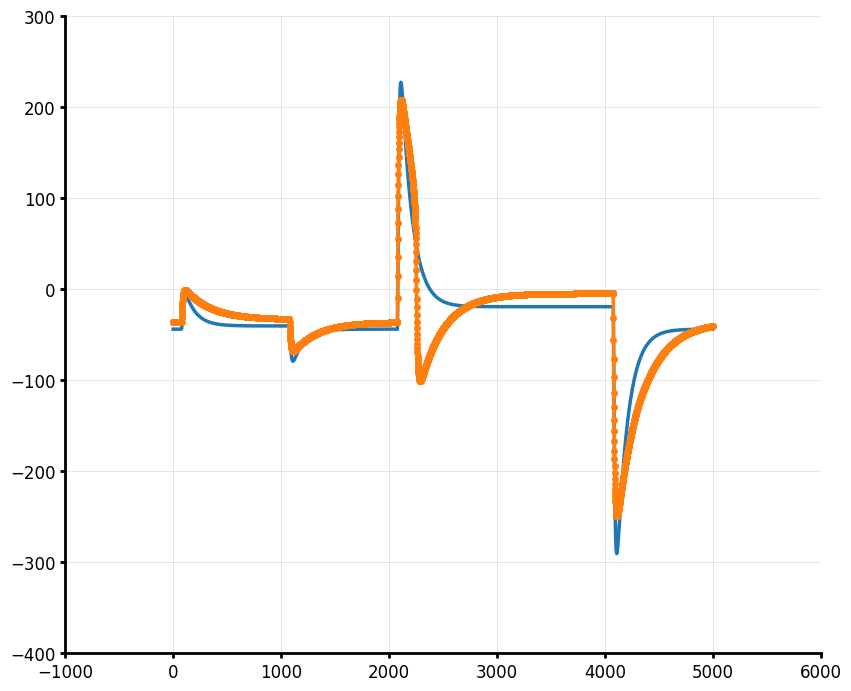

In [23]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(data, '.-')

 ### real_data_minimize


In [24]:
def get_full_trace(a):
    data = pd.read_csv( a ,delimiter= '\t', header=None, skiprows = 11)
    for k in range(1,21):
        print(np.mean(data[k][:77]),np.mean(data[k][4877:]))
#get_full_trace('../data/training/2020_12_19_0035 I-V INa 11,65 pF.atf')

In [25]:
def line(x,k,l):
    return k*x+l

In [26]:
def no_drift(data):
    v = 1
    final_data = np.zeros(len(data)*(len(data.columns)-1))
    list_drift = np.concatenate((np.arange(0,77),np.arange(1500,2077))) 
    dif=len(data[0])
    for k in range(1,len(data.columns)):
        x_0 = np.arange(dif)
        x = np.arange((k-1) * dif, k * dif)
        data_drift = data[k][list_drift]
        popt,pcov = scop.curve_fit(line, list_drift,data_drift)
        drift = line(x_0,*popt)[::v]
        final_data[(k-1) * dif : k * dif] = data[k] - drift
        #plt.plot(x[::v], data[k][::v])
        #plt.plot(x[::v], data[k][::v]-drift[::v])
        #plt.plot(x[::v], drift[::v])
    return final_data


In [27]:
def no_drift_single(data):
    v = 1
    final_data = np.zeros(len(data))#*(len(data.columns)-1))
    list_drift = np.concatenate((np.arange(0,77),np.arange(1500,2077))) 
    dif=len(data)
    x_0 = np.arange(dif)
    x = np.arange(0, dif)
    data_drift = data[list_drift]
    popt,pcov = scop.curve_fit(line, list_drift,data_drift)
    drift = line(x_0,*popt)[::v]
    final_data = data - drift
    #plt.plot(x[::v], data[k][::v])
    #plt.plot(x[::v], data[k][::v]-drift[::v])
    #plt.plot(x[::v], drift[::v])
    return final_data


In [28]:
#x_true_log = np.load('one_start_scop_minimize.npy')
sample_weight = np.zeros(5000)
w1 = 1
w2 = 5
w3 = 10
#sample_weight[:]+= 1
if True:
    sample_weight[:70] += w2
    sample_weight[90:500]+= w3
    sample_weight[500:1070] += w2
    sample_weight[1090:1500] += w3
    sample_weight[1500:2070] += w2
    sample_weight[2100:2400] += 50
    sample_weight[2400:4070] += w2
    sample_weight[4090:4500] += w3
    sample_weight[4500:] += w2
#sample_weight[k_list_1[2]+40:k_list_1[2]+900] += 1
#sample

In [30]:
%matplotlib inline
plt.style.use('../styles/general.mplstyle')

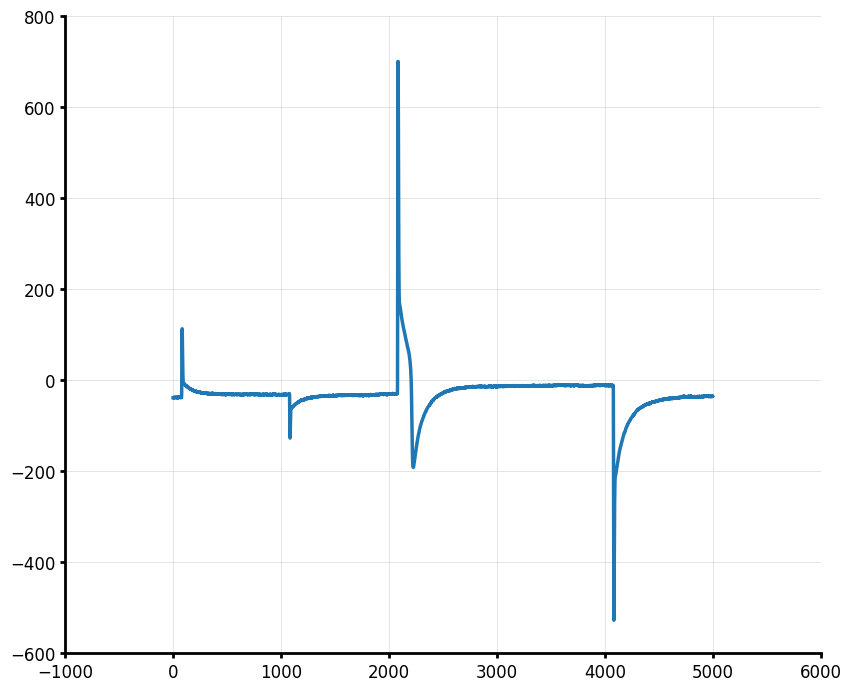

In [67]:
real_data = pd.read_csv('../data/training/2020_12_19_0035 I-V INa 11,65 pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
#real_data = pd.read_csv('../data/training/2020_12_21_0007 I-V INa 15.80pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
#real_data = pd.read_csv('../data/training/2020_12_22_0006 I-V INa 25.16pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
#real_data = pd.read_csv('../data/training/2020_12_22_0032 I-V INa 21.05pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
#real_data = pd.read_csv('../data/training/2020_12_23_0007 I-V INa E4031 33.16pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
#real_data = pd.read_csv('../data/training/2020_12_26_0000 I-V INa 36.60pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
#real_data = pd.read_csv('../data/training/2020_12_26_0014 I-V INa 15.78pF.atf' ,delimiter= '\t', header=None, skiprows = 11)

real_data_small = real_data[14]

#real_data_all = no_drift(real_data)#np.concatenate([real_data[k] for k in range(1,21)])

real_data_all = np.concatenate([real_data[k] for k in range(1,21)])
sample_weight_all = np.concatenate([sample_weight for k in range(1,21)])


#p0 = np.array([6e-16, 1.6e-10, 90e+1,  3.9,-8.21,   12.8,    6.3,   1.75e02,    6.72,  -21.65,    5e6,   5e5,5e1,   5e-2,20,53,5,0.66, 5])
                   
bounds = ([1e-18, 1e-13,#C_f , C 
           1e-06, 1e-06, 1e-03, 1e-03,# a0_m , b0_m , delta_m , s_m 
           1e-06, 1e-06, 1e-03, 1e-03,#a0_h , b0_h , delta_h , s_h
           1e-06, 1e-06, 1e-03, 1e-03, 1e-8,#a0_j , b0_j , delta_j , s_j, tau_j_const
           1e+05, 1e+03, 1e-05, 1e-05,#R , R_f , g_max , g_leak
           1e-04, 1e-04, 1e-04, 1e-04, -5e+01],#v_half_m , v_half_h , k_m , k_h
          
          [1e-10, 1e-10,#C_f , C 
           1e+06, 1e+06, 1e+03, 1e+03,# a0_m , b0_m , delta_m , s_m 
           1e+06, 1e+06, 1e+03, 1e+03,#a0_h , b0_h , delta_h , s_h
           1e+06, 1e+06, 1e+03, 1e+03, 1e+06,#a0_j , b0_j , delta_j , s_j, tau_j_const
           1e+10, 1e+12, 1e+05, 1e+05, #R , R_f , g_max , g_leak
           1e+02, 1e+02, 1e+02, 1e+02, 5e+01])#v_half_m , v_half_h , k_m , k_h
log_bounds = np.vstack([np.concatenate((np.log(bounds[0][:-1]), bounds[0][-1:]))
                        , np.concatenate((np.log(bounds[1][:-1]), bounds[1][-1:]))]).T
kwargs_for_count = dict(v_list = v_all,
              k_list = k_all,
              t = t_all,
              log_scale = True,
              graph = False,
              sample_weight = sample_weight_all)
plt.plot(real_data_small)

In [32]:
#%%time
#res = scop.minimize(loss, p0, bounds=log_bounds, args=(real_data_all, kwargs_for_count),method = 'Nelder-Mead',
#               options={ 'adaptive':True})
res = scop.minimize(loss, x_true_log, bounds=log_bounds, args=(real_data_all, kwargs_for_count),method = 'Nelder-Mead',\
                    options={ 'adaptive':True, 'maxiter':5000})

/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


In [33]:
#np.save("res_maxiter_1000",res.x)

In [34]:
loss(res.x, real_data_all, kwargs_for_count)

494.434494725183

In [131]:
%matplotlib notebook

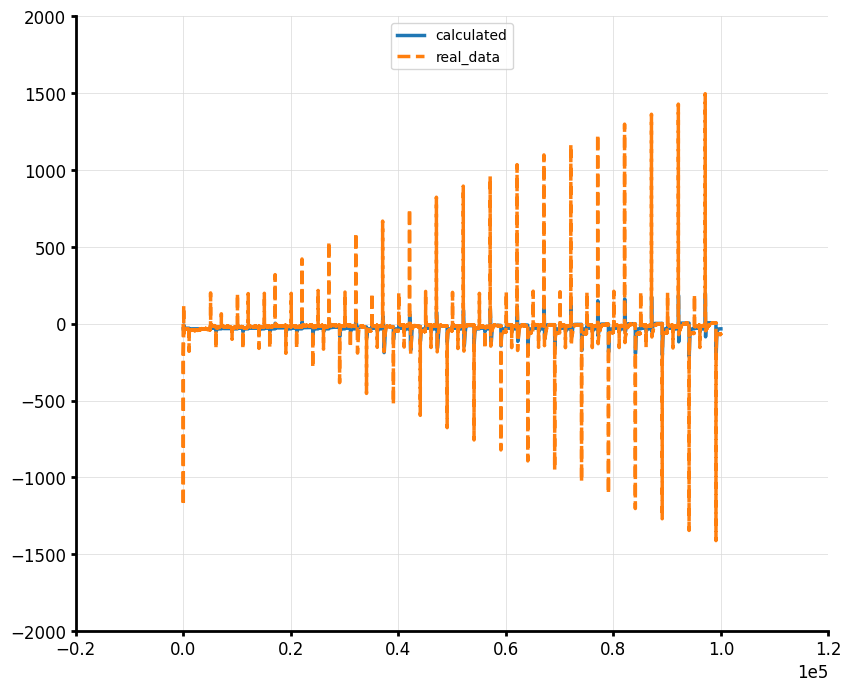

In [35]:
kwargs= dict(v_list = v_all,
              k_list = k_all,
              t = t_all,
              log_scale = True,
              graph = True,
              sample_weight = sample_weight_all)
plt.plot(calculate_I_out(res.x, kwargs_for_count), label = 'calculated')
plt.plot(real_data_all,'--', label = 'real_data')

plt.legend()


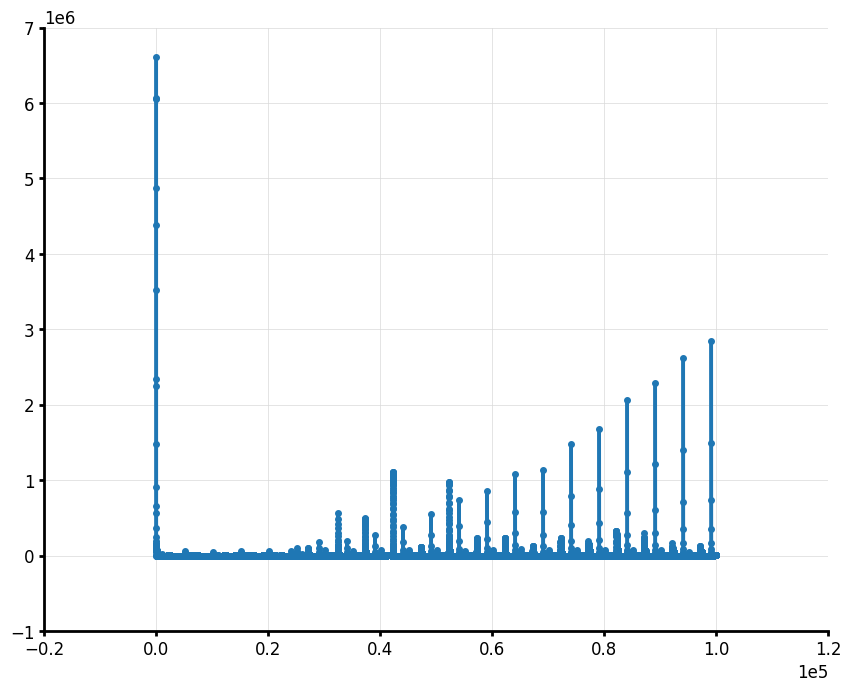

In [36]:
x = calculate_I_out(res.x, kwargs_for_count) - real_data_all
x **= 2
x *= sample_weight_all
plt.plot(x, '.-', label = 'calculated')
#lt.xlim(2050,2200)

In [37]:
np.sqrt(x[x <= 0.25e5].mean())

42.10813978173837

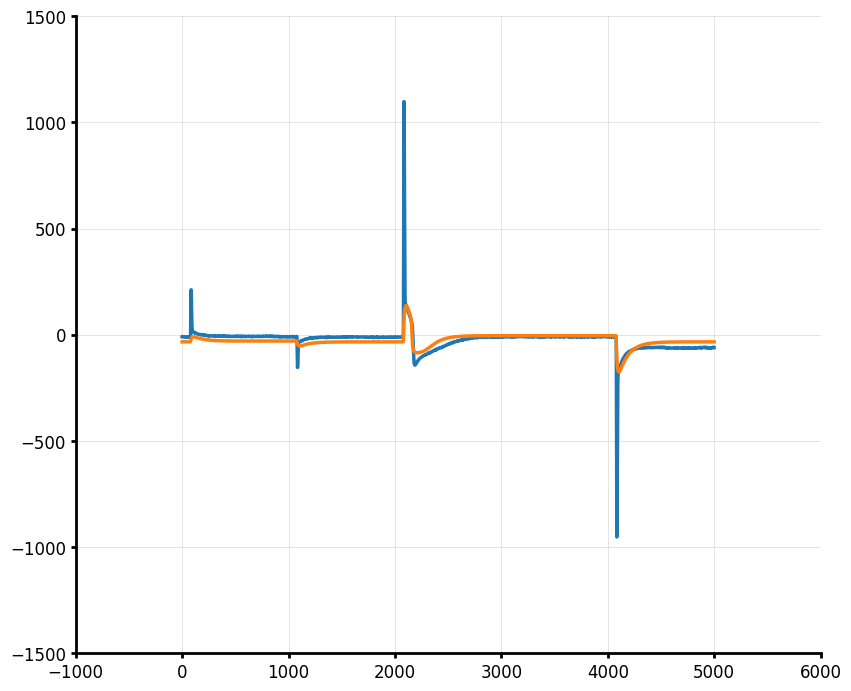

In [38]:
kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = False,
              sample_weight = sample_weight)
plt.plot(real_data_small)
plt.plot(calculate_I_out(res.x, kwargs))

In [39]:
%matplotlib inline

plt.style.use('../styles/general.mplstyle')

<ipython-input-5-94e6110c9262>:242: RuntimeWarning: overflow encountered in exp
  +  b0_m * np.exp( v_graph / (-delta_m)))


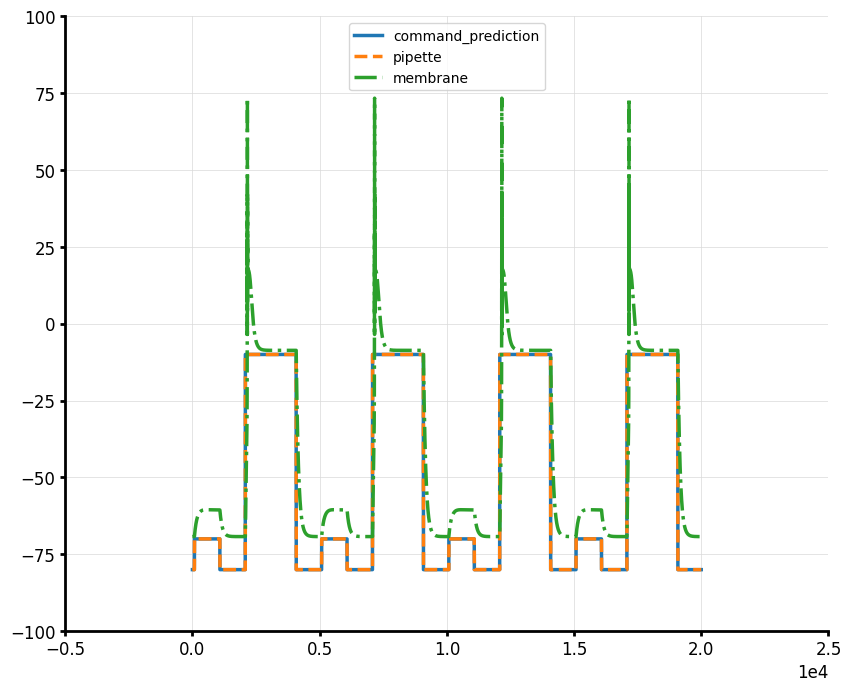

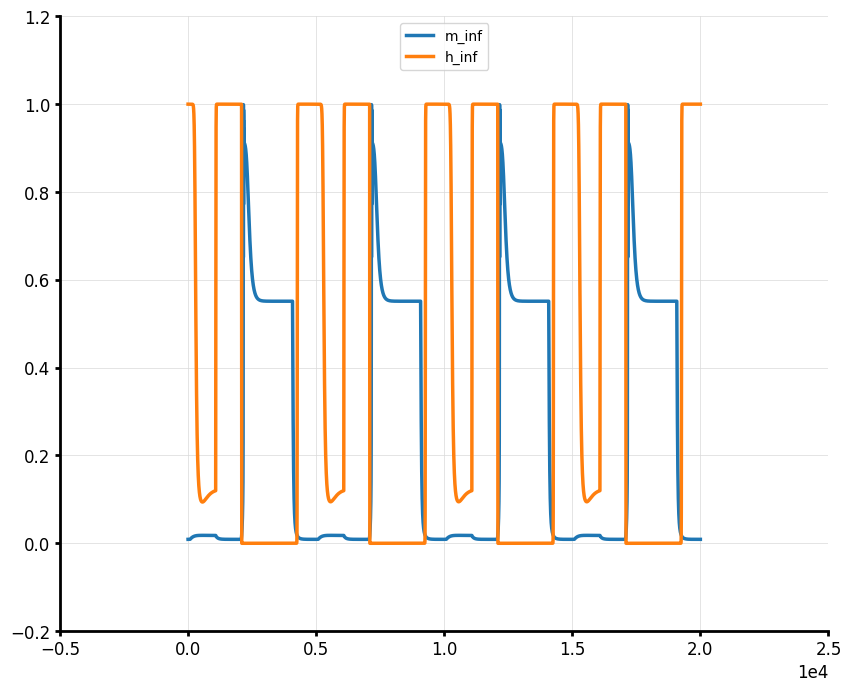

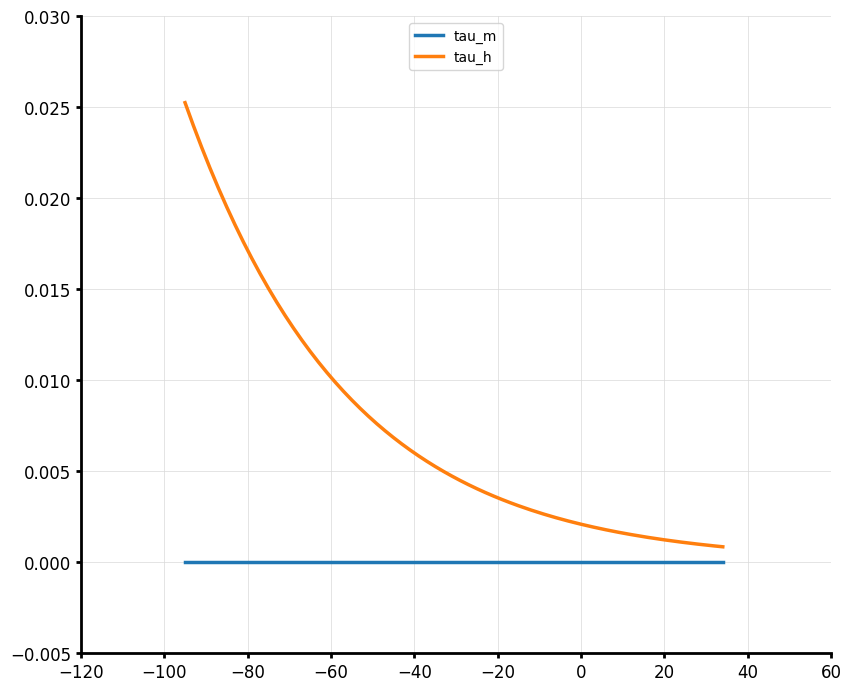

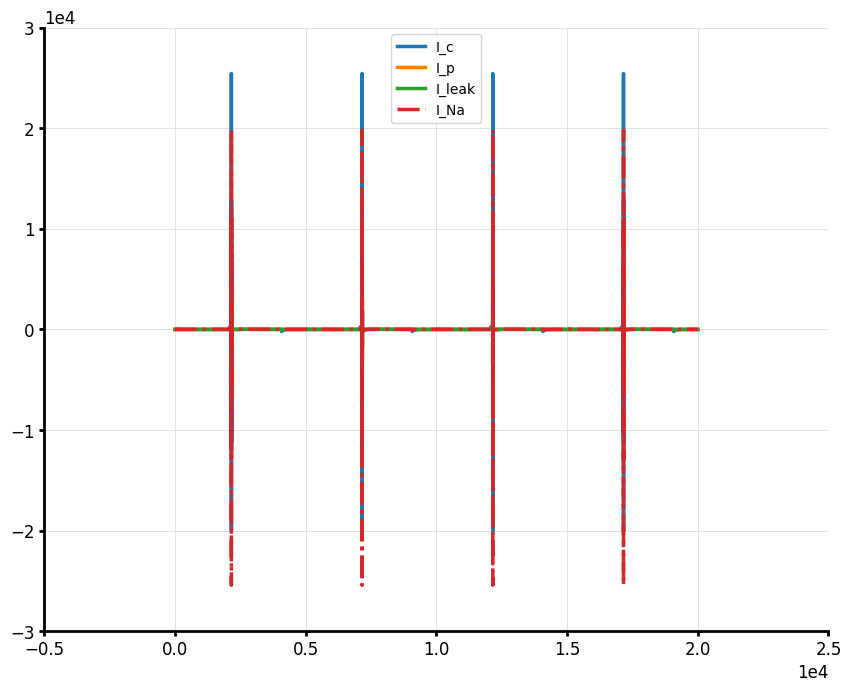

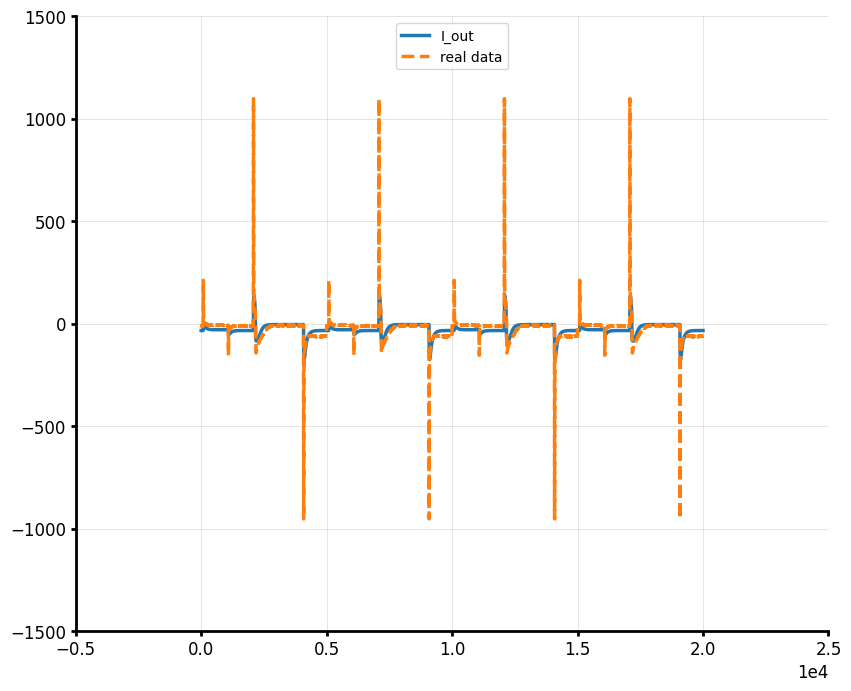

In [40]:
real_data_small = np.concatenate([real_data[14] for k in range(4)])
t_2 = np.concatenate([t for k in range(4)])
#v_2 = np.concatenate([v_list_1 for k in range(4)])
v_2 = np.concatenate([np.array([-80,-70,-80, -10]) for k in range(4)])
k_2 = np.concatenate([k_list_1+5000*k for k in range(4)])
v_2 = np.concatenate([v_2,[-80]])
kwargs = dict(v_list = v_2,
              k_list = k_2,
              t = t_2,
              log_scale = True,
              graph = True)#,
              #sample_weight = sample_weight)
calculate_I_out(res.x, kwargs)
plt.plot(real_data_small, '--', label = 'real data')
plt.legend()

In [41]:
for k in range(len(res.x)):
    print(names[k], ' = ',np.exp(res.x)[k])

C_f  =  6.221390314005253e-15
C  =  1.6536613068480837e-11
a0_m  =  66324395446.07971
b0_m  =  51.71668883130834
delta_m  =  0.12356342278123225
s_m  =  2472.124598692047
a0_h  =  0.10609082578386489
b0_h  =  478.19442754942804
delta_h  =  37.85612160559546
s_h  =  49.86567255155402
a0_j  =  4509.940405719925
b0_j  =  5.081209360809512e-05
delta_j  =  8.191356077308972
s_j  =  35.600635173988266
tau_j_const  =  0.002033444359310228
R  =  323419410.91043615
R_f  =  33847.970745003084
g_max  =  2618.936013121014
g_leak  =  0.4776406401834469
v_half_m  =  11.199643204812912
v_half_h  =  61.147114788276426
k_m  =  12.340724109382277
k_h  =  0.2825384062093537
v_off  =  1.000214680616827


### differential_evolution

In [38]:
%%time
res = scop.differential_evolution(loss,
                                  bounds=log_bounds,
                                  args=(real_data_small, kwargs_for_count),
                                  maxiter=10, # I don't want to wait too long
                                  #disp=True,
                                  workers=-1,
                                  seed=42,
                                  )

/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_differentialevolution.py:495: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  warnings.warn("differential_evolution: the 'workers' keyword has"


RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'

In [39]:
loss(res.x, real_data_small, kwargs_for_count)

ValueError: Found input variables with inconsistent numbers of samples: [20000, 100000]

In [ ]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(real_data_small, '--')
#plt.xlim(0, 1000)

### dual_annealing

In [ ]:
%%time
#res = scop.dual_annealing(loss, bounds=log_bounds, x0 = x_true_log, args=(real_data_small, kwargs_for_count), seed=42)

In [ ]:
res

In [ ]:
loss(res.x, real_data_small, kwargs)

In [ ]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(real_data_small, '--')